In [1]:
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import xtrack as xt
import pickle

import matplotlib.pyplot as plt
from scipy.stats import *
from madxtools.particles import *

import sys
import os
current_working_directory = os.getcwd()
module_directory = os.path.join(current_working_directory, '..')
absolute_module_directory = os.path.abspath(module_directory)
sys.path.append(absolute_module_directory)
from t07_functions import *

from scipy.stats import pearsonr, spearmanr, kendalltau

In [2]:
initial_quad_strength = [-0.28611781,  0.48998671,  0.4186652 , -0.09344907, -0.07466559,
        0.15355204, 29.08274068, 60.83029156]

In [3]:
num_part = 5000
seed = np.random.randint(low=1, high=int(4e9), size=num_part, dtype=np.uint32)

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("simple_seq.seq")

p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

madx.input(f'''
beam, particle=PROTON, pc={p};
use, sequence=simple_seq;
''')

madx.input('SEQEDIT, sequence=simple_seq;')
madx.input(f'MOVE, ELEMENT = OCT1, TO={initial_quad_strength[6]};')
madx.input('MOVE, ELEMENT = Q1, TO=1, FROM=OCT1;')
madx.input(f'MOVE, ELEMENT = OCT2, TO={initial_quad_strength[7]};')
madx.input('MOVE, ELEMENT = Q2, TO=1, FROM=OCT2;')
madx.input('ENDEDIT;')
madx.use(sequence="simple_seq")
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

line = xt.Line.from_madx_sequence(
    sequence=madx.sequence.simple_seq,
    allow_thick=True,
    enable_align_errors=True,
    deferred_expressions=True,
)
line.particle_ref = xt.Particles(mass0=xt.PROTON_MASS_EV,
                            gamma0=madx.sequence.simple_seq.beam.gamma)

tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="qf1", end="simple_seq$end", init=tw_init)

nemitt_x = exn
nemitt_y = eyn
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c


Converting sequence "simple_seq":   0%|          | 0/18 [00:00<?, ?it/s]

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


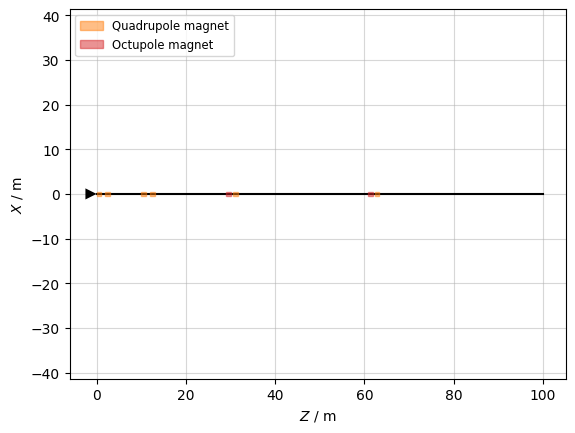

In [4]:
sv = line.survey()
import xplt
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

Output(layout=Layout(height='auto', width='70%'))

Output(layout=Layout(height='auto', width='70%'))

Output(layout=Layout(height='auto', width='70%'))

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c


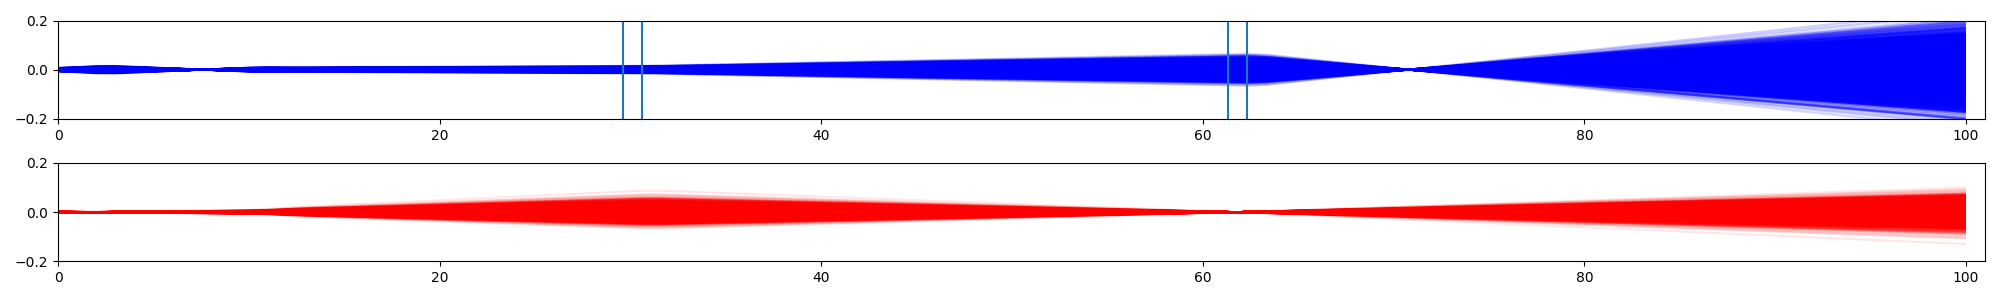

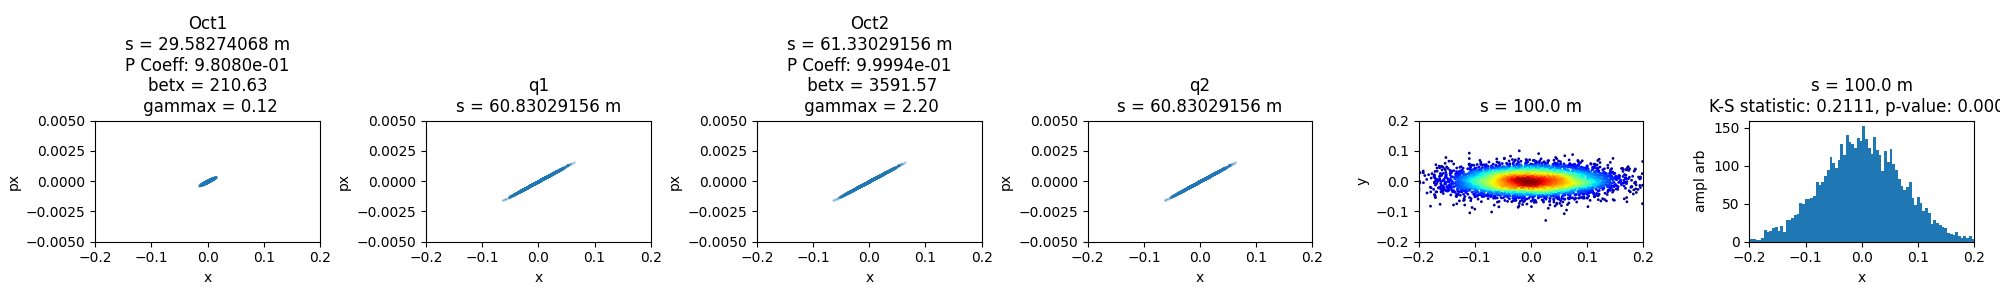

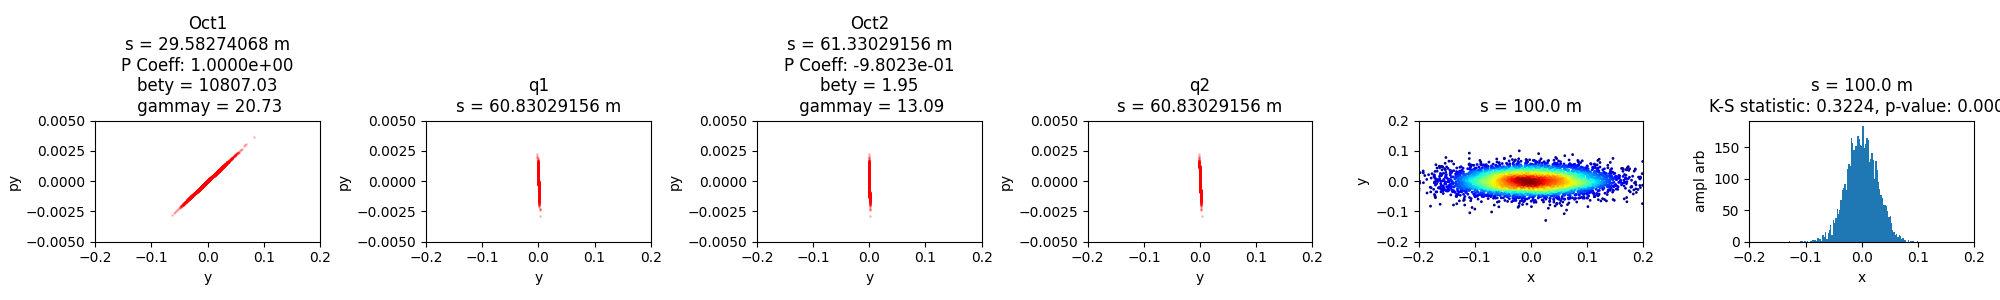

In [5]:
from ipywidgets import interact, FloatSlider, Output, widgets, Layout, HBox
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
%matplotlib widget

def update_and_plot(change):

    global num_part
    p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)
    
    # Change and track
    line['qf1'].k1 = k_QF1.value
    line['qd2'].k1 = k_QD2.value
    line['qf3'].k1 = k_QF3.value
    line['qd4'].k1 = k_QD4.value
    line['q1'].k1 = q1_sli.value
    line['q2'].k1 = q2_sli.value
    line['oct1'].knl = [0,0,0,oct1_sli.value]
    line['oct2'].knl = [0,0,0,oct2_sli.value]

    # Loop through the tracking
    x_norm, px_norm = xp.generate_2D_gaussian(num_part)
    y_norm, py_norm = xp.generate_2D_gaussian(num_part)
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    # part._init_random_number_generator(seed=seed)
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
    line_df = line.to_pandas()

    with Output1:
        ax[0].clear()
        ax[1].clear()

        lines = [list(zip(line.record_last_track.s[i], line.record_last_track.x[i])) for i in range(len(line.record_last_track.s))]
        line_collection = LineCollection(lines, colors='blue', alpha=0.1)
        ax[0].add_collection(line_collection)
        ax[0].set_ylim(-0.2, 0.2)
        ax[0].set_xlim(0, 101)

        lines = [list(zip(line.record_last_track.s[i], line.record_last_track.y[i])) for i in range(len(line.record_last_track.s))]
        line_collection = LineCollection(lines, colors='red', alpha=0.1)
        ax[1].add_collection(line_collection)
        ax[1].set_ylim(-0.2, 0.2)
        ax[1].set_xlim(0, 101)

        ax[0].axvline(line_df[line_df.name == 'oct1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'q1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'oct2'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'q2'].s.iloc[0])


    with Output2:
        ax2[0].clear()
        ax2[1].clear()
        ax2[2].clear()
        ax2[3].clear()
        ax2[4].clear()
        ax2[5].clear()

        # First octupoles
        target_s = line_df[line_df.name == 'oct1'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        pearson_coeff, p_value = pearsonr(x, px)
        betx, alfx, gammax, epsilon = twiss_parameters_from_distribution(x, px)

        ax2[0].scatter(x, px, alpha=0.2, s=1)
        ax2[0].set_xlabel("x")
        ax2[0].set_ylabel("px")
        ax2[0].set_title(f"Oct1\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbetx = {betx:.2f}\n gammax = {gammax:.2f}")
        ax2[0].set_ylim(-5e-3, 5e-3)
        ax2[0].set_xlim(-2e-1, 2e-1)

        # Quadrupole q1
        target_s = 50
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        ax2[1].scatter(x, px, alpha=0.2, s=1)
        ax2[1].set_xlabel("x")
        ax2[1].set_ylabel("px")
        ax2[1].set_title(f"q1\ns = {s_array[s_index]} m")
        ax2[1].set_ylim(-5e-3, 5e-3)
        ax2[1].set_xlim(-2e-1, 2e-1)
        
        # Second octupoles
        target_s = line_df[line_df.name == 'oct2'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        pearson_coeff, p_value = pearsonr(x, px)
        betx, alfx, gammax, epsilon = twiss_parameters_from_distribution(x, px)

        ax2[2].scatter(x, px, alpha=0.2, s=1)
        ax2[2].set_xlabel("x")
        ax2[2].set_ylabel("px")
        ax2[2].set_title(f"Oct2\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\n betx = {betx:.2f}\n gammax = {gammax:.2f}")
        ax2[2].set_ylim(-5e-3, 5e-3)
        ax2[2].set_xlim(-2e-1, 2e-1)

        # Quadrupole q2
        target_s = 60
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]
        ax2[3].scatter(x, px, alpha=0.2, s=1)
        ax2[3].set_xlabel("x")
        ax2[3].set_ylabel("px")
        ax2[3].set_title(f"q2\ns = {s_array[s_index]} m")
        ax2[3].set_ylim(-5e-3, 5e-3)
        ax2[3].set_xlim(-2e-1, 2e-1)

        # DUT
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        y = line.record_last_track.y[:,s_index]

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax2[4].scatter(x, y, c=z, s=1, cmap="jet")
        ax2[4].set_xlabel("x")
        ax2[4].set_ylabel("y")
        ax2[4].set_title(f"s = {s_array[s_index]} m")
        ax2[4].set_ylim(-0.2, 0.2)
        ax2[4].set_xlim(-0.2, 0.2)

        # Histogram
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.y[:,s_index]

        data = x
        data_min, data_max = np.min(data), np.max(data)
        uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
        statistic, p_value = kstest(data, uniform_dist.cdf)


        ax2[5].hist(x, bins=100)
        ax2[5].set_xlabel("x")
        ax2[5].set_ylabel("ampl arb")
        ax2[5].set_title(f"s = {s_array[s_index]} m\nK-S statistic: {statistic:.4f}, p-value: {p_value:.4f}")
        ax2[5].set_xlim(-0.2, 0.2)

    with Output3:
        ax3[0].clear()
        ax3[1].clear()
        ax3[2].clear()
        ax3[3].clear()
        ax3[4].clear()
        ax3[5].clear()

        # First octupoles
        target_s = line_df[line_df.name == 'oct1'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        pearson_coeff, p_value = pearsonr(y, py)
        bety, alfy, gammay, epsilon = twiss_parameters_from_distribution(y, py)

        ax3[0].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[0].set_xlabel("y")
        ax3[0].set_ylabel("py")
        ax3[0].set_title(f"Oct1\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbety = {bety:.2f}\n gammay = {gammay:.2f}")
        ax3[0].set_ylim(-5e-3, 5e-3)
        ax3[0].set_xlim(-2e-1, 2e-1)

        # Quadrupole q1
        target_s = 50
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        ax3[1].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[1].set_xlabel("y")
        ax3[1].set_ylabel("py")
        ax3[1].set_title(f"q1\ns = {s_array[s_index]} m")
        ax3[1].set_ylim(-5e-3, 5e-3)
        ax3[1].set_xlim(-2e-1, 2e-1)
        
        # Second octupoles
        target_s = line_df[line_df.name == 'oct2'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        pearson_coeff, p_value = pearsonr(y, py)
        bety, alfy, gammay, epsilon = twiss_parameters_from_distribution(y, py)

        ax3[2].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[2].set_xlabel("y")
        ax3[2].set_ylabel("py")
        ax3[2].set_title(f"Oct2\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbety = {bety:.2f}\n gammay = {gammay:.2f}")
        ax3[2].set_ylim(-5e-3, 5e-3)
        ax3[2].set_xlim(-2e-1, 2e-1)

        # Quadrupole q2
        target_s = 60
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]
        ax3[3].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[3].set_xlabel("y")
        ax3[3].set_ylabel("py")
        ax3[3].set_title(f"q2\ns = {s_array[s_index]} m")
        ax3[3].set_ylim(-5e-3, 5e-3)
        ax3[3].set_xlim(-2e-1, 2e-1)

        # DUT
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        y = line.record_last_track.y[:,s_index]

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax3[4].scatter(x, y, c=z, s=1, cmap="jet")
        ax3[4].set_xlabel("x")
        ax3[4].set_ylabel("y")
        ax3[4].set_title(f"s = {s_array[s_index]} m")
        ax3[4].set_ylim(-0.2, 0.2)
        ax3[4].set_xlim(-0.2, 0.2)

        # Histogram
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        y_norm = line.record_last_track.y[:,s_index]

        data = y
        data_min, data_max = np.min(data), np.max(data)
        uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
        statistic, p_value = kstest(data, uniform_dist.cdf)

        ax3[5].hist(y, bins=100)
        ax3[5].set_xlabel("x")
        ax3[5].set_ylabel("ampl arb")
        ax3[5].set_title(f"s = {s_array[s_index]} m\nK-S statistic: {statistic:.4f}, p-value: {p_value:.4f}")
        ax3[5].set_xlim(-0.2, 0.2)

k_QF1 = widgets.FloatSlider(
    value=initial_quad_strength[0],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QF1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

k_QD2 = widgets.FloatSlider(
    value=initial_quad_strength[1],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QD2',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

k_QF3 = widgets.FloatSlider(
    value=initial_quad_strength[2],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QF3:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

k_QD4 = widgets.FloatSlider(
    value=initial_quad_strength[3],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QD4:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

q1_sli= widgets.FloatSlider(
    value=initial_quad_strength[4],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='q1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

q2_sli = widgets.FloatSlider(
    value=initial_quad_strength[5],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='q2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

oct1_sli = widgets.FloatSlider(
    value=0.0,
    min=-600,
    max=600,
    step=0.01,
    description='oct1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

oct2_sli = widgets.FloatSlider(
    value=0.0,
    min=-600,
    max=600,
    step=0.01,
    description='oct2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

Output1 = widgets.Output(layout=Layout(width='70%', height='auto'))
Output2 = widgets.Output(layout=Layout(width='70%', height='auto'))
Output3 = widgets.Output(layout=Layout(width='70%', height='auto'))
display(Output1, Output2, Output3, HBox([k_QF1, k_QD2, k_QF3, k_QD4]), HBox([q1_sli, q2_sli, oct1_sli, oct2_sli]))

with Output1:
    fig, ax = plt.subplots(2,1, figsize=(20, 3), tight_layout=True)

with Output2:
    fig2, ax2 = plt.subplots(1,6, figsize=(20, 3), tight_layout=True)

with Output3:
    fig3, ax3 = plt.subplots(1,6, figsize=(20, 3), tight_layout=True)

k_QF1.observe(update_and_plot, names='value')
k_QD2.observe(update_and_plot, names='value')
k_QF3.observe(update_and_plot, names='value')
k_QD4.observe(update_and_plot, names='value')
q1_sli.observe(update_and_plot, names='value')
q2_sli.observe(update_and_plot, names='value')
oct1_sli.observe(update_and_plot, names='value')
oct2_sli.observe(update_and_plot, names='value')

update_and_plot(change=1)

# Optimize on the beam spot at target

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c


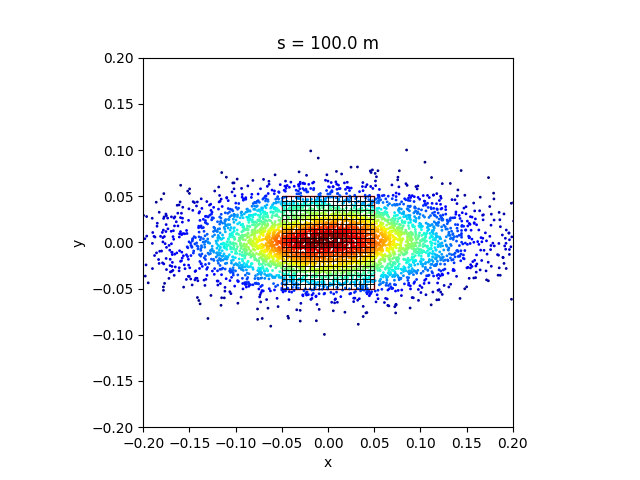

In [6]:
p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

# Change and track
line['qf1'].k1 = k_QF1.value
line['qd2'].k1 = k_QD2.value
line['qf3'].k1 = k_QF3.value
line['qd4'].k1 = k_QD4.value
line['q1'].k1 = q1_sli.value
line['q2'].k1 = q2_sli.value
line['oct1'].knl = [0,0,0,oct1_sli.value]
line['oct2'].knl = [0,0,0,60]

# Loop through the tracking
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
# part._init_random_number_generator(seed=seed)
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
line_df = line.to_pandas()

fig, ax = plt.subplots()

target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)
x = line.record_last_track.x[:,s_index]
y = line.record_last_track.y[:,s_index]

rect_l = 0.05
rect = patches.Rectangle((0.0-rect_l, 0.0-rect_l), 2*rect_l, 2*rect_l, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x, y, c=z, s=1, cmap="jet")

# Number of divisions per side
n_divisions = 20
side_length = 2 * rect_l / n_divisions

# Loop to create and add small square patches
for i in range(n_divisions):
    for j in range(n_divisions):
        small_rect = patches.Rectangle((i * side_length - rect_l, j * side_length - rect_l), side_length, side_length, linewidth=0.5, edgecolor='k', facecolor='none')
        ax.add_patch(small_rect)

# Initialize an empty list to hold the count of points in each small square
counts = []

# Loop over each small square to calculate its bounds and count the points within
for i in range(n_divisions):
    for j in range(n_divisions):
        # Calculate the bounds of the small square
        x_min = i * side_length - rect_l
        x_max = (i + 1) * side_length - rect_l
        y_min = j * side_length - rect_l
        y_max = (j + 1) * side_length - rect_l
        
        # Count how many points fall within these bounds
        count = np.sum((x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max))
        counts.append(count)

# Reshape the counts to match the grid layout for easier interpretation
counts_matrix = np.reshape(counts, (n_divisions, n_divisions))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"s = {s_array[s_index]} m")
ax.set_ylim(-0.2, 0.2)
ax.set_xlim(-0.2, 0.2)
ax.set_aspect("equal")

3.276549251880704


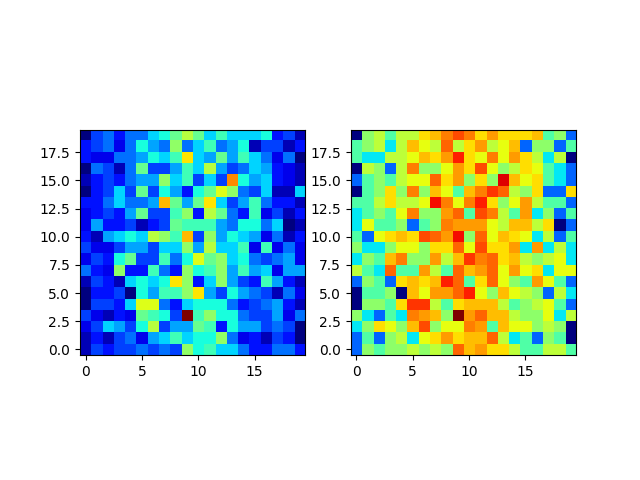

In [7]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(counts_matrix, cmap="jet", origin='lower')
ax[0].set_aspect("equal")
ax[1].imshow(np.log1p(counts_matrix), cmap="jet", origin='lower')
ax[1].set_aspect("equal")
print(np.std(counts_matrix))

In [251]:
def custom_uniformity_score(matrix, x, y, rect_l):
    uniformity_penalty = np.std(matrix)  # Lower is better
    out_of_bounds_penalty = np.sum((x < -rect_l) | (x > rect_l) | (y < -rect_l) | (y > rect_l))
    emptiness_penalty = np.sum(matrix == 0)
    
    # Combine the penalties; adjust weights as necessary
    uniformity_weight = 1.0
    out_of_bounds_weight = 0.01  # Adjust this weight to increase/decrease the penalty for out-of-bounds points
    emptiness_weight = 100.0
    
    # Calculate total score
    score = (uniformity_penalty * uniformity_weight) + \
            (out_of_bounds_penalty * out_of_bounds_weight) + \
            (emptiness_penalty * emptiness_weight)
    return score

def kl_divergence(n_divisions, num_part, counts_matrix):

        number_of_bins = n_divisions**2
        target_per_bin = num_part/number_of_bins # I divide the total number of particles by the number of bins
        P = np.ones((n_divisions, n_divisions))*target_per_bin # I create a square matrix with the correct number of bins
        P = P/P.sum()

        Q = counts_matrix.astype(float)/num_part # This is the matrix where I counted how many particles fall in the bins. The total number of particles inside this region is smaller than num_part.
        Q = np.where(Q==0, np.finfo(float).eps, Q) # Replace any zeros in matrix Q with the smallest positive float number to prevent division by zero errors

        D_KL = np.sum(P * np.log(P / Q)) # Calculate the KL divergence
    
        return D_KL

In [253]:
import scipy.optimize as optimize
import pybobyqa

fetch_rows = lambda indices, attribute: np.array([getattr(twiss.row(index), attribute) for index in indices])

iter = 0
def optimise(params):
    global iter
    print(f"Iteration = {iter}")
    iter+=1
    kQF1, kQD2, kQF3, kQD4, kQ1, kQ2, koct1, koct2 = params
    print(params)

    p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

    # Change and track
    line['qf1'].k1 = kQF1
    line['qd2'].k1 = kQD2
    line['qf3'].k1 = kQF3
    line['qd4'].k1 = kQD4
    line['q1'].k1 = kQ1
    line['q2'].k1 = kQ2
    line['oct1'].knl = [0,0,0,koct1]
    line['oct2'].knl = [0,0,0,koct2]

    # Loop through the tracking
    num_part = 1000
    x_norm, px_norm = xp.generate_2D_gaussian(num_part)
    y_norm, py_norm = xp.generate_2D_gaussian(num_part)
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    # part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
    # line_df = line.to_pandas()

    target_s = 100
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    y = line.record_last_track.y[:,s_index]

    rect_l = 0.05

    # Number of divisions per side
    n_divisions = 20
    side_length = 2* rect_l / n_divisions

    # Initialize an empty list to hold the count of points in each small square
    counts = []
    # Loop over each small square to calculate its bounds and count the points within
    for i in range(n_divisions):
        for j in range(n_divisions):
            # Calculate the bounds of the small square
            x_min = i * side_length - rect_l
            x_max = (i + 1) * side_length - rect_l
            y_min = j * side_length - rect_l
            y_max = (j + 1) * side_length - rect_l
            
            # Count how many points fall within these bounds
            count = np.sum((x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max))
            counts.append(count)

    # Reshape the counts to match the grid layout for easier interpretation
    counts_matrix = np.reshape(counts, (n_divisions, n_divisions))

    # objective =  custom_uniformity_score(counts_matrix, x, y, rect_l)
    objective = kl_divergence(n_divisions, num_part, counts_matrix)
    
    print (f"OJECTIVE = {objective}")
    return objective

initial_guess = np.array([initial_quad_strength[0], initial_quad_strength[1], initial_quad_strength[2], initial_quad_strength[3], -0.0, 0.0, 0, 0])

lower = np.array([initial_quad_strength[0] - initial_quad_strength[0]*0.5,
                  initial_quad_strength[1] - initial_quad_strength[1]*0.5,
                  initial_quad_strength[2] - initial_quad_strength[2]*0.5,
                  initial_quad_strength[3] - initial_quad_strength[3]*0.5,
                  -0.5,
                  -0.5,
                  0,
                  0])
upper = np.array([initial_quad_strength[0] + initial_quad_strength[0]*0.5,
                  initial_quad_strength[1] + initial_quad_strength[1]*0.5,
                  initial_quad_strength[2] + initial_quad_strength[2]*0.5,
                  initial_quad_strength[3] + initial_quad_strength[3]*0.5,
                  0.5,
                  0.5,
                  400,
                  400])

soln = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.0001, scaling_within_bounds=True, seek_global_minimum=True, objfun_has_noise=True, maxfun=2000)
print(soln)

/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/pybobyqa/solver.py:797: RuntimeWarning: x0 below lower bound, adjusting
  warnings.warn("x0 below lower bound, adjusting", RuntimeWarning)


Iteration = 0
[-0.28611781  0.48998671  0.4186652  -0.09344907  0.          0.
  0.          0.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
OJECTIVE = 15.69109644436569
Iteration = 1
[-0.42917671  0.48998671  0.4186652  -0.09344907  0.          0.
  0.          0.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
OJECTIVE = 13.140439194753283
Iteration = 2
[-0.28611781  0.73498007  0.4186652  -0.09344907  0.          0.
  0.          0.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
OJECTIVE = 23.98569556873936
Iteration = 3
[-0.28611781  0.48998671  0.6279978  -0.09344907  0.          0.
  0.          0.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
OJECTIVE = 16.61981762231438
Iteration = 4
[-0.28611781  0.48998671  0.4186652  -0.1401736   0.          0.
  0.          0.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
OJECTIVE = 8.873739339234444
Iteration = 5
[-0.286117

In [254]:
soln.x

array([-4.29176715e-01,  5.42016277e-01,  4.56066887e-01, -1.13181084e-01,
       -1.14945360e-01, -5.58654777e-02,  1.61684530e+02,  0.00000000e+00])

/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_33970/3408219394.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(x, y, s=1, cmap="jet")


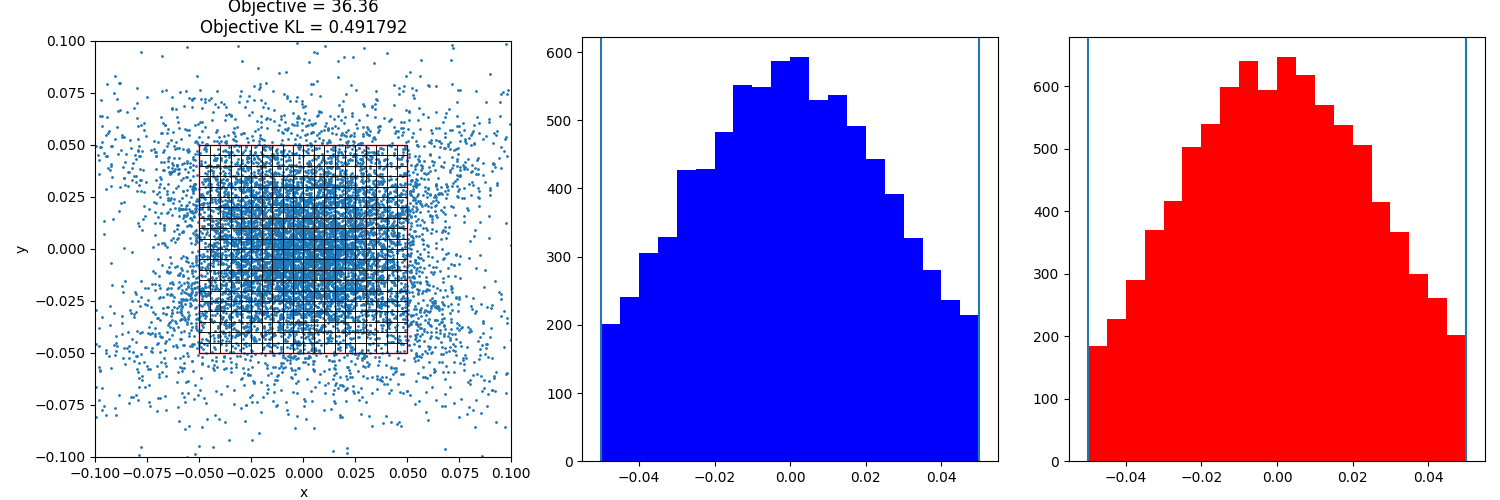

In [255]:
# Change and track
line['qf1'].k1 = soln.x[0]
line['qd2'].k1 = soln.x[1]
line['qf3'].k1 = soln.x[2]
line['qd4'].k1 = soln.x[3]
line['q1'].k1 = soln.x[4]
line['q2'].k1 = soln.x[5]
line['oct1'].knl = [0,0,0,soln.x[6]]
line['oct2'].knl = [0,0,0,soln.x[7]]

# Loop through the tracking
num_part = 2*5000
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
# part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
line_df = line.to_pandas()



fig, ax = plt.subplots(1,3, figsize=(15,5), tight_layout=True)

target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)
x = line.record_last_track.x[:,s_index]
y = line.record_last_track.y[:,s_index]

rect_l = 0.05
rect = patches.Rectangle((0.0-rect_l, 0.0-rect_l), 2*rect_l, 2*rect_l, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax[0].scatter(x, y, c=z, s=1, cmap="jet")
ax[0].scatter(x, y, s=1, cmap="jet")

# Number of divisions per side
n_divisions = 20
side_length = 2 * rect_l / n_divisions

# Loop to create and add small square patches
for i in range(n_divisions):
    for j in range(n_divisions):
        small_rect = patches.Rectangle((i * side_length - rect_l, j * side_length - rect_l), side_length, side_length, linewidth=0.5, edgecolor='k', facecolor='none')
        ax[0].add_patch(small_rect)

# Initialize an empty list to hold the count of points in each small square
counts = []

# Loop over each small square to calculate its bounds and count the points within
for i in range(n_divisions):
    for j in range(n_divisions):
        # Calculate the bounds of the small square
        x_min = i * side_length - rect_l
        x_max = (i + 1) * side_length - rect_l
        y_min = j * side_length - rect_l
        y_max = (j + 1) * side_length - rect_l
        
        # Count how many points fall within these bounds
        count = np.sum((x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max))
        counts.append(count)

# Reshape the counts to match the grid layout for easier interpretation
counts_matrix = np.reshape(counts, (n_divisions, n_divisions))

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title(f"s = {s_array[s_index]} m")
ax[0].set_ylim(-0.1, 0.1)
ax[0].set_xlim(-0.1, 0.1)
ax[0].set_aspect("equal")

objective =  custom_uniformity_score(counts_matrix, x, y, rect_l)
objective_kl = kl_divergence(n_divisions, num_part, counts_matrix)
ax[0].set_title(f"Objective = {objective:.2f}\nObjective KL = {objective_kl:2f}")

ax[1].hist(x,bins=n_divisions, range=(-rect_l,rect_l), color="b");
ax[2].hist(y,bins=n_divisions, range=(-rect_l,rect_l), color="r");

ax[1].axvline(-rect_l)
ax[1].axvline(rect_l)
ax[2].axvline(-rect_l)
ax[2].axvline(rect_l)

/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/eliottjohnson/git_repos/venv3_9/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


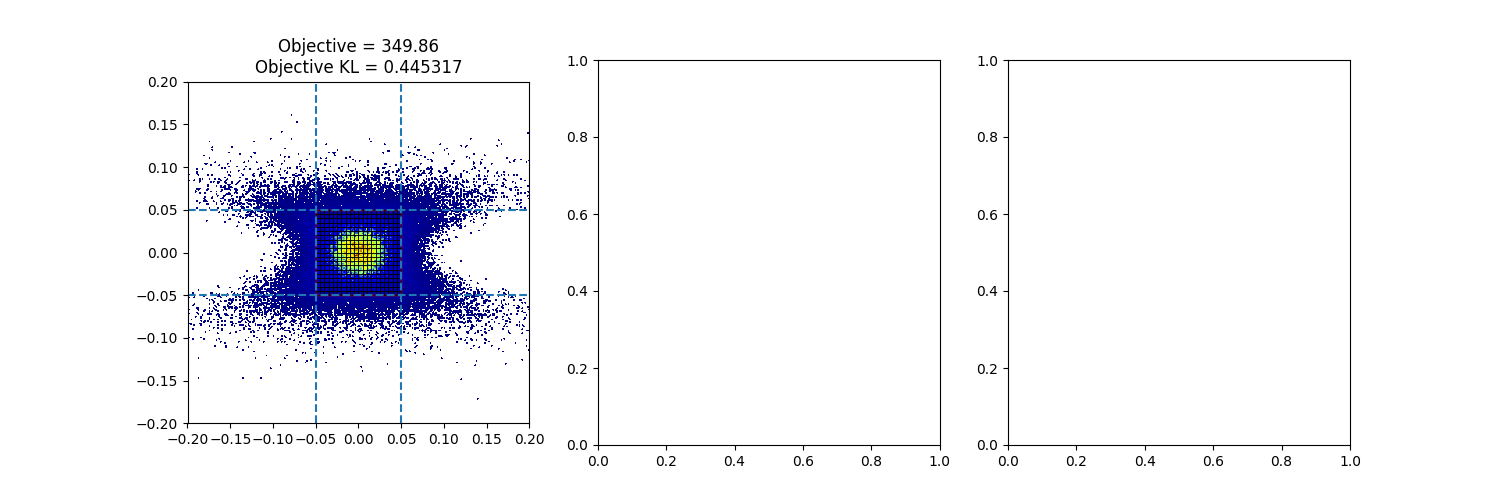

(-0.1, 0.1)

In [256]:
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

def using_mpl_scatter_density_with_subplots(fig, ax, x, y):
    # fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'scatter_density'})
    density = ax[0].scatter_density(x, y, cmap=white_jet)
    # fig.colorbar(density, ax=ax[0], label='Number of points per pixel')
    ax[0].set_aspect("equal")
    ax[0].axvline(-rect_l, ls="--")
    ax[0].axvline(rect_l, ls="--")
    ax[0].axhline(-rect_l, ls="--")
    ax[0].axhline(rect_l, ls="--")
    ax[0].set_ylim(-0.2, 0.2)
    ax[0].set_xlim(-0.2, 0.2)
    plt.show()
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)
white_jet = LinearSegmentedColormap.from_list('white_jet', [
    (0, '#ffffff'),    # White at the lowest value
    (1e-20, '#00007F'), # Dark blue just above the lowest value
    (0.35, '#0000FF'),  # Blue
    (0.5, '#7FFF7F'),   # Cyan to Green transition
    (0.65, '#FFFF00'),  # Yellow
    (1, '#7F0000'),    # Dark red at the highest value
], N=256)

# Change and track
line['qf1'].k1 = soln.x[0]
line['qd2'].k1 = soln.x[1]
line['qf3'].k1 = soln.x[2]
line['qd4'].k1 = soln.x[3]
line['q1'].k1 = soln.x[4]
line['q2'].k1 = soln.x[5]
line['oct1'].knl = [0,0,0,soln.x[6]]
line['oct2'].knl = [0,0,0,soln.x[7]]


# Loop through the tracking
num_part = 20*5000
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
# part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
line_df = line.to_pandas()

fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={'projection': 'scatter_density'})

target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)
x = line.record_last_track.x[:,s_index]
y = line.record_last_track.y[:,s_index]

rect_l = 0.05
rect = patches.Rectangle((0.0-rect_l, 0.0-rect_l), 2*rect_l, 2*rect_l, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

# Number of divisions per side
n_divisions = 20
side_length = 2 * rect_l / n_divisions

# Loop to create and add small square patches
for i in range(n_divisions):
    for j in range(n_divisions):
        small_rect = patches.Rectangle((i * side_length - rect_l, j * side_length - rect_l), side_length, side_length, linewidth=0.5, edgecolor='k', facecolor='none')
        ax[0].add_patch(small_rect)

# Initialize an empty list to hold the count of points in each small square
counts = []

# Loop over each small square to calculate its bounds and count the points within
for i in range(n_divisions):
    for j in range(n_divisions):
        # Calculate the bounds of the small square
        x_min = i * side_length - rect_l
        x_max = (i + 1) * side_length - rect_l
        y_min = j * side_length - rect_l
        y_max = (j + 1) * side_length - rect_l
        
        # Count how many points fall within these bounds
        count = np.sum((x >= x_min) & (x < x_max) & (y >= y_min) & (y < y_max))
        counts.append(count)

# Reshape the counts to match the grid layout for easier interpretation
counts_matrix = np.reshape(counts, (n_divisions, n_divisions))

objective =  custom_uniformity_score(counts_matrix, x, y, rect_l)
objective_kl = kl_divergence(n_divisions,num_part, counts_matrix)
ax[0].set_title(f"Objective = {objective:.2f}\nObjective KL = {objective_kl:2f}")

using_mpl_scatter_density_with_subplots(fig, ax, x, y)
ax[1].hist(x,bins=n_divisions, range=(-rect_l,rect_l), color="b");
ax[2].hist(y,bins=n_divisions, range=(-rect_l,rect_l), color="r");

ax[1].axvline(-rect_l)
ax[1].axvline(rect_l)
ax[2].axvline(-rect_l)
ax[2].axvline(rect_l)

ax[0].set_ylim(-0.1, 0.1)
ax[0].set_xlim(-0.1, 0.1)

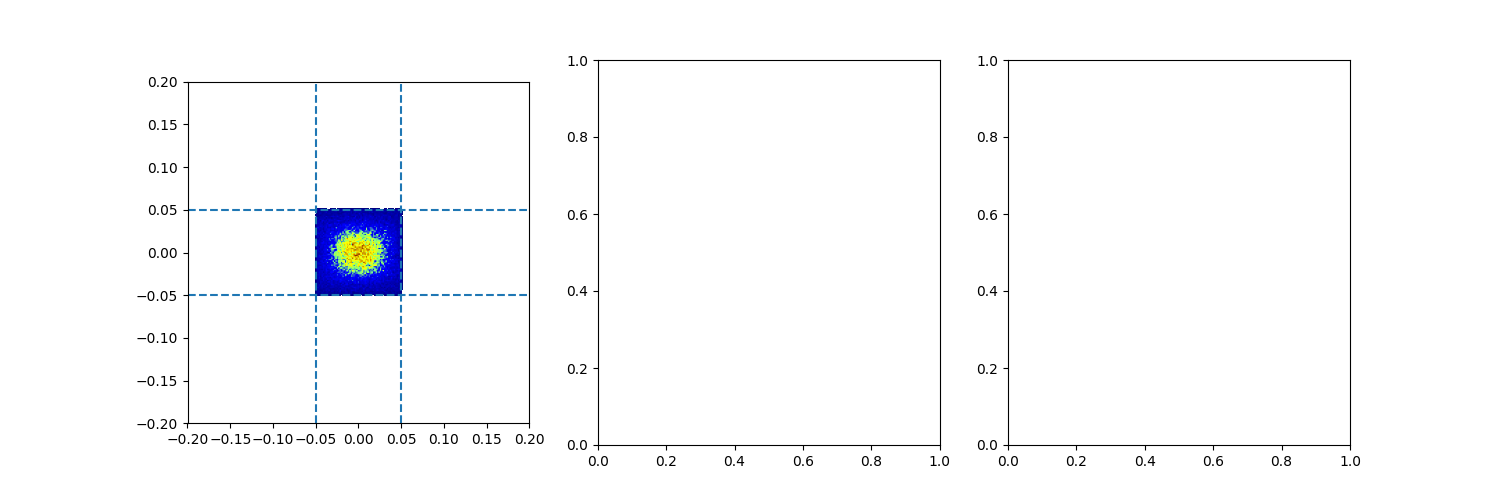

(-0.1, 0.1)

In [257]:
fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={'projection': 'scatter_density'})
condition = (np.abs(x) <= rect_l) & (np.abs(y) <= rect_l)

# Filter the points
x_filtered = x[condition]
y_filtered = y[condition]

using_mpl_scatter_density_with_subplots(fig, ax, x_filtered, y_filtered)
ax[1].hist(x_filtered,bins=n_divisions, range=(-rect_l,rect_l), color="b");
ax[2].hist(y_filtered,bins=n_divisions, range=(-rect_l,rect_l), color="r");
ax[0].set_ylim(-0.1, 0.1)
ax[0].set_xlim(-0.1, 0.1)